In [1]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
import dataframe_image as dfi

import gensim #the library for Topic modelling

from gensim.models.ldamulticore import LdaMulticore

from gensim import corpora, models

from nltk.corpus import stopwords
import string
from nltk.stem.wordnet import WordNetLemmatizer


In [2]:
from main_function import clean_data

In [3]:
xl = "C:\\Users\\zachi\\Desktop\\final_project_22\\data_nov_21.xlsx"

month = 'November'

new_df = clean_data (xl,month)



c:\Users\zachi\FOA-TAU-Data-analysis-project\inner organization report\main_function.py:29: FutureWarning: The default value of regex will change from True to False in a future version.
  posts_description=posts_description.str.lower().str.replace('[^\w\s]','')


In [4]:
# {#Open a user file

# user_file = "C:\\Users\\zachi\\Desktop\\final_project_22\\data_nov_21.xlsx"
# df=pd.read_excel(user_file)

# #Remove unnecessary column - "removed 1"

# df.drop(columns=['Removed 1'],inplace=True)

# #Make the Category column easier to understand 

# df=df.replace({'Category' : { 'Y' : "Antisemitic", 'W' : "Non-Antisemitic", 'U' : "Anti-Zionist" }})



# #Convert "time stamp" to english

# df = df.rename(columns={"חותמת זמן":"Time stamp"})

# #Change the date time to the d/m/y

# from datetime import datetime
# df['Time stamp'] = pd.to_datetime(df['Time stamp']).dt.date #This function convert the date text into dt.date type


# #Fix the Summary column's text

# df = df.replace(r'\n',' ', regex=True) 

# posts_description = df["A short summary of the content- write briefly in your own words "]


# #get rid of NaNs in category

# list = ["Anti-Zionist",
# "Antisemitic",
# "Non-Antisemitic"]

# df = df.loc[df['Category'] .isin(list)]
# #This line is keeping rows which have one of the categories


# # ###### /\ convert textual user input into dat recognition

# user_input = "2021-11-01"
# the_user_target_date = df["Time stamp"]>user_input
# new_df = df[the_user_target_date]


Analyze content type by date range & platform

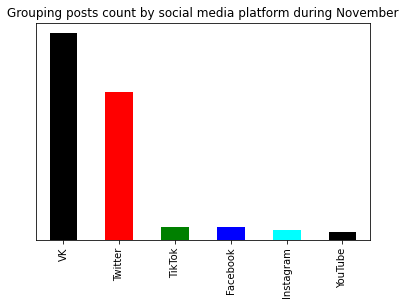

In [5]:
# Count posts for each platform in the data set

posts_in_platforms = new_df["Platform"].value_counts().plot(kind="bar",color=['black', 'red', 'green', 'blue', 'cyan'],title = "Grouping posts count by social media platform during" + " " + month)

posts_in_platforms.get_yaxis().set_visible(False)
###### /\ build a function if possible

plt.savefig("posts_in_platforms.png",dpi='figure',
        bbox_inches= 'tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)


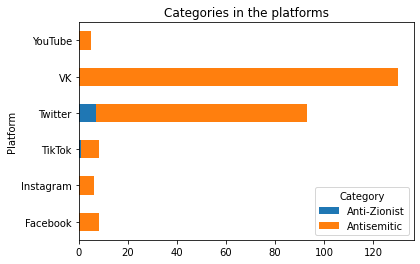

In [6]:
#Mapping the category type through the platforms

df_group_=new_df.groupby(['Category', 'Platform'])['Platform'].count().unstack('Category').fillna(0).astype(int)
categories_per_each_platform = df_group_.plot(kind='barh', stacked=True,mark_right = True ,title = "Categories in the platforms")

#categories_per_each_platform.get_yaxis().set_visible(False)

plt.savefig("categories_per_each_platform.png",dpi='figure',
        bbox_inches= 'tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)

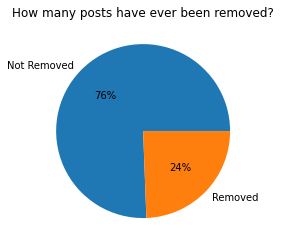

In [7]:
#Cheking the percentage of posts removing in general view

status = new_df["Removed"]

#df.groupby("Category").agg({status:"mean"})

# category = df["Category"] ###### /\


general_removal_view = status.value_counts() #get general info about the removal process of platforms

general_removal_view_plot = general_removal_view.plot(kind = "pie" , autopct='%1.0f%%', title = "How many posts have ever been removed?", textprops={'color':"black"}) 

general_removal_view_plot.get_yaxis().set_visible(False)

plt.savefig("general_removal_view_plot.png",dpi='figure',
        bbox_inches= 'tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)

Content removal data (by category)

In [8]:
new_df.groupby(['Category', 'Removed'])['Removed'].count().unstack('Removed').fillna(0).astype(int)

#This function is grouping the DF by the removal status & the category
outpot_category_removal_stats= new_df.groupby(['Removed', 'Category'])['Category'].count().unstack('Category').fillna(0).astype(int).reindex(index = ['Removed','Not Removed']).astype("int")

In [9]:
#Saving the counting chart as a picture

dfi.export(outpot_category_removal_stats,"outpot_category_removal_stats_plot.png")


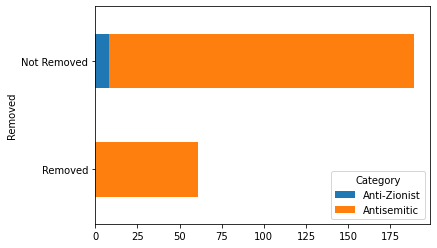

In [10]:
outpot_category_removal_stats_plot = outpot_category_removal_stats.plot(kind='barh', stacked=True,mark_right = True )


#outpot_category_removal_stats_plot.get_yaxis().set_visible(False)

plt.savefig("outpot_category_removal_stats_plot.png",dpi='figure',
        bbox_inches= 'tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)


Content removal data (by platform)

In [11]:
#Gropping the data by removal status + platform and plot a percentage summary of the data

outpot_category_removal_stats_by_platform= new_df.groupby(['Removed', 'Platform'])['Platform'].count().unstack('Platform').fillna(0).astype(int).reindex(index = ['Removed','Not Removed'])

precentage_chart = outpot_category_removal_stats_by_platform/outpot_category_removal_stats_by_platform[outpot_category_removal_stats_by_platform.columns].sum()*100

precentage_chart_plot = precentage_chart.round(1).astype(str) +'%'

dfi.export(precentage_chart_plot,"precentage_chart_plot.png")



Text analysis - find central keywords in the provided posts


In [13]:
#Make a new DF which focusing on removed posts only 

only_removed_content = new_df["Removed"]!="Not Removed"
only_removed_content = new_df[only_removed_content]

#Cleaning text symbols and make it all letters lower case

removed_posts_description = only_removed_content["A short summary of the content- write briefly in your own words "]


In [14]:
#Use this only if nltk package donwloding needed

import nltk
nltk.download('punkt')
from nltk import word_tokenize,sent_tokenize
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zachi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zachi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

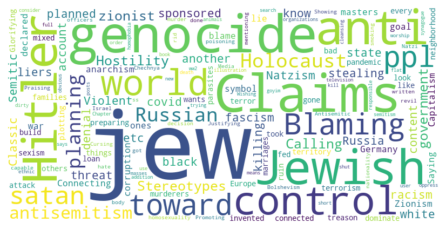

In [22]:
#Finding the most popular keywords in the removed content 

stop = stopwords.words('english')
new_list=["picture","video","pic","cartoon","photo","int","dtype","Claiming","claiming","non","dtype","int64"," int64 ",  "int64 ",  " int64","dtype: int64"]
stop.extend(new_list)


from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


text = " ".join(word for word in removed_posts_description.astype(str))
wordcloud = WordCloud(stopwords=stop, background_color="white", width=800, height=400).generate(text)

plt.axis("off")


plt.tight_layout(pad=0)

plt.imshow(wordcloud, interpolation='bilinear')


plt.savefig("wordcloud_new.png",dpi='figure',
        bbox_inches= 'tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)

In [23]:
#A full pdf report extraction

from matplotlib.backends.backend_pdf import PdfPages
from fpdf import FPDF

pdf = FPDF()

pdf.add_page()

pdf.set_font('Arial', size = 16)

pdf.cell(40)

pdf.cell(75, 10,'Inner report', 0, 2, 'C')

pdf.cell(80, 10, '', 0, 2, 'C')
pdf.cell(-17)

pdf.image("posts_in_platforms.png")

pdf.cell(90, 20, '', 0, 2, 'C')
pdf.cell(-3)

pdf.cell(90, 10, '', 0, 2, 'C')
pdf.cell(-3)


# pdf.image("sort_by_language.png")

# pdf.cell(90, 10, '', 0, 2, 'C')
# pdf.cell(10)

pdf.image("categories_per_each_platform.png")

pdf.cell(90, 20, '', 0, 2, 'C')
pdf.cell(7)

pdf.cell(90, 10, '', 0, 2, 'C')
pdf.cell(7)

pdf.image("general_removal_view_plot.png")

pdf.cell(90, 20, '', 0, 2, 'C')
pdf.cell(-2)

pdf.cell(90, 10, '', 0, 2, 'C')
pdf.cell(-2)

pdf.image("outpot_category_removal_stats_plot.png")

pdf.cell(100, 10, '', 0, 2, 'C')
pdf.cell(-7)

pdf.cell(100, 10, '', 0, 2, 'C')
pdf.cell(-7)

pdf.image("precentage_chart_plot.png")

pdf.cell(100, 10, '', 0, 2, 'C')
pdf.cell(4)

pdf.cell(100, 10, '', 0, 2, 'C')
pdf.cell(4)

pdf.cell(100, 10, '', 0, 2, 'C')
pdf.cell(4)


pdf.image("wordcloud_new.png")


pdf.output("Inner report.pdf")

os.startfile("Inner report.pdf")
